# Ideal Parameter Analysis ($\delta=3$, $\tau=1.25$, $\alpha=2.25$) ($\delta$ upper bound, $\alpha$ upper bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 3
expected_tau = 1.25
expected_alpha = 2.25

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

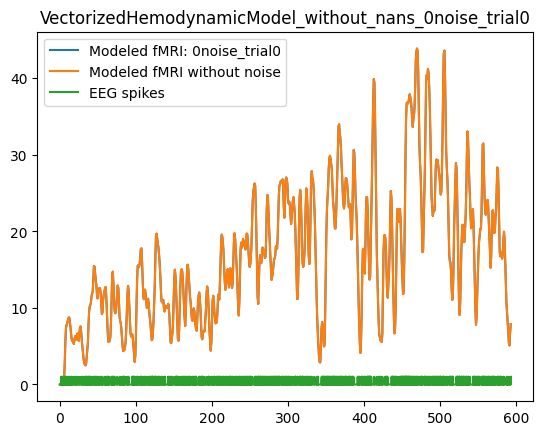

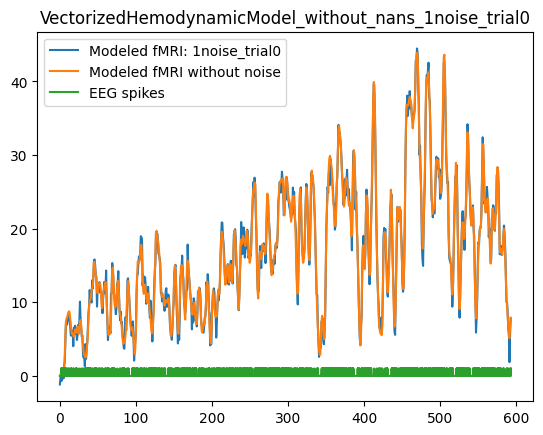

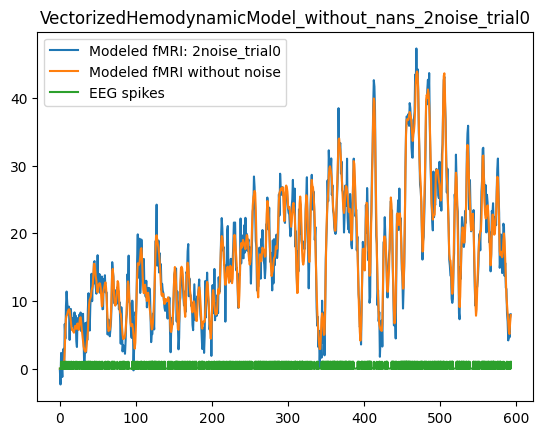

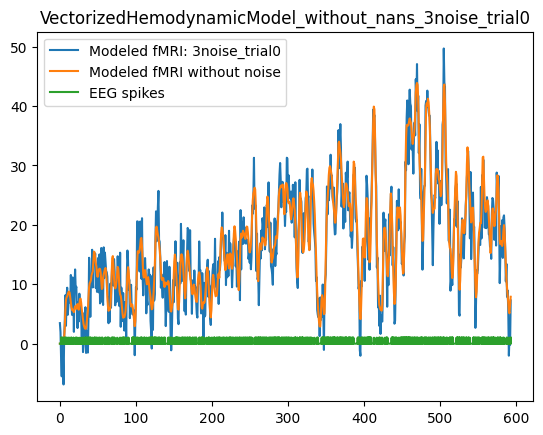

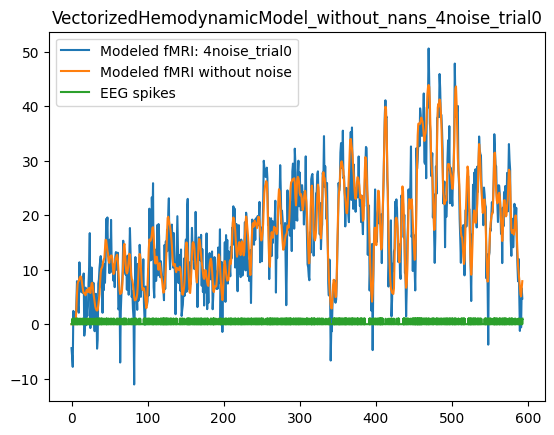

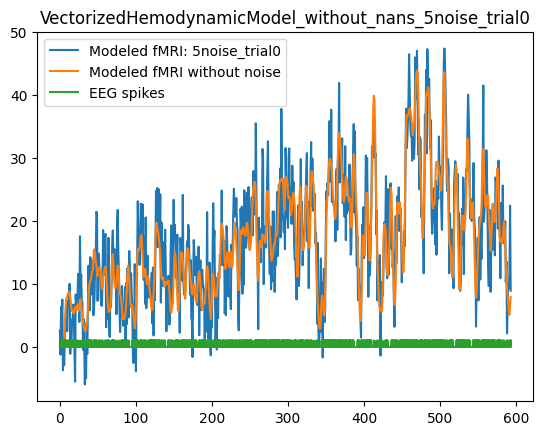

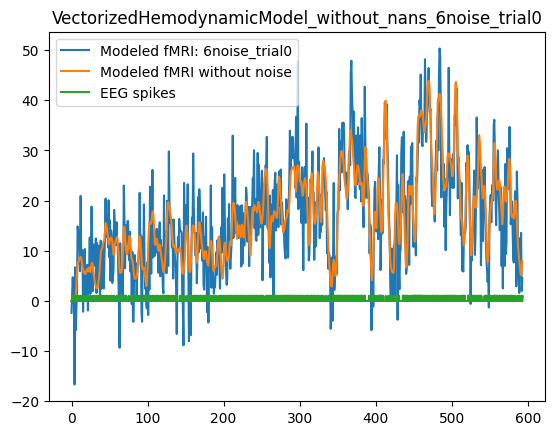

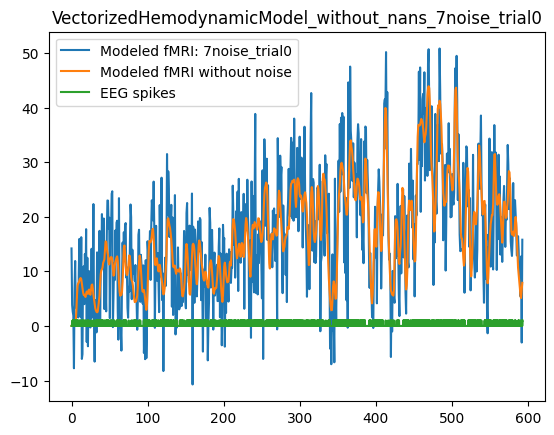

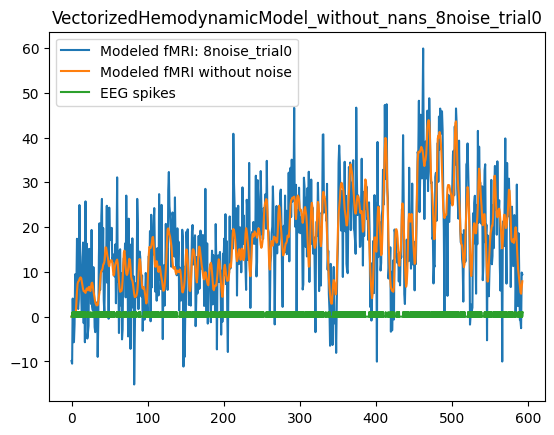

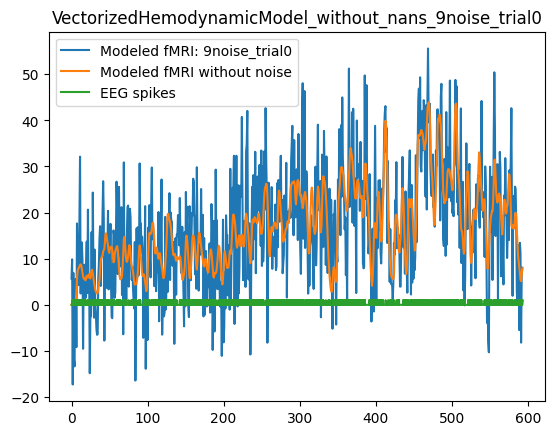

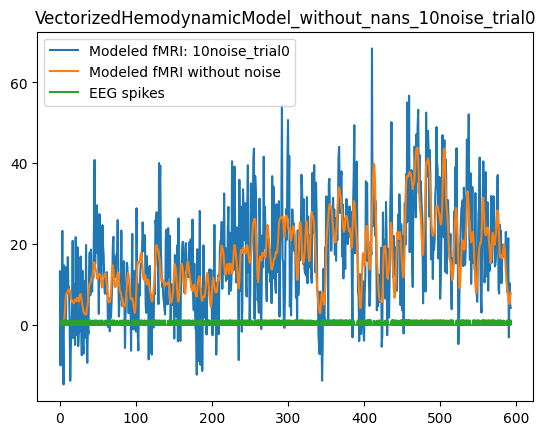

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 3, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2.25, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=3, tau=1.25, alpha=2.25


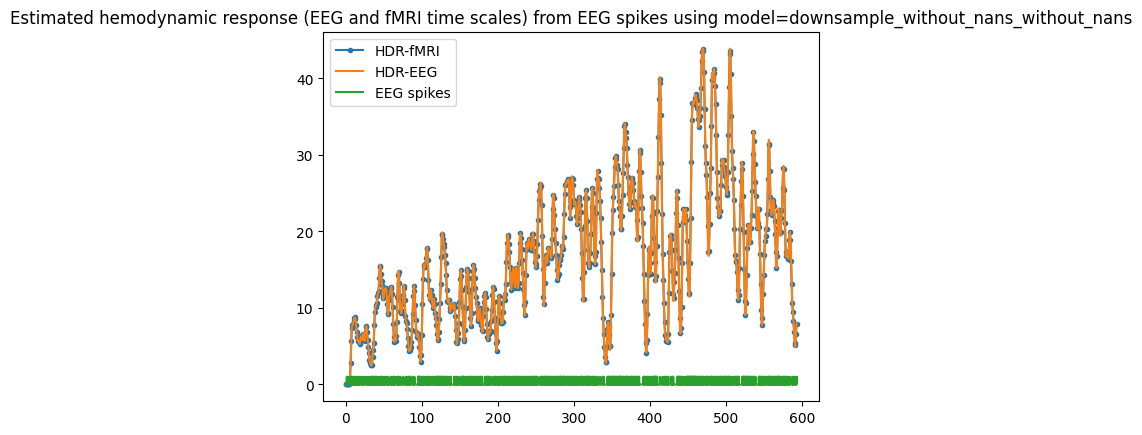

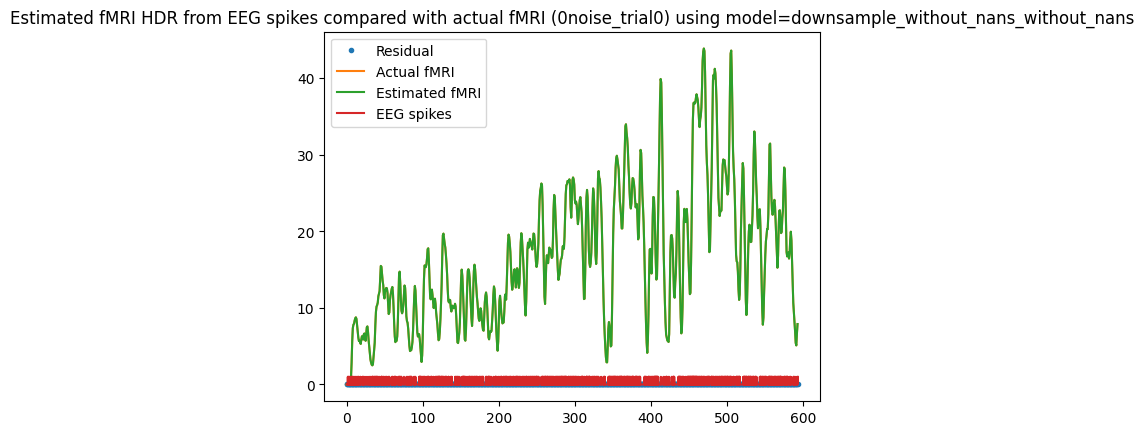

Residual Variance is 0.000000


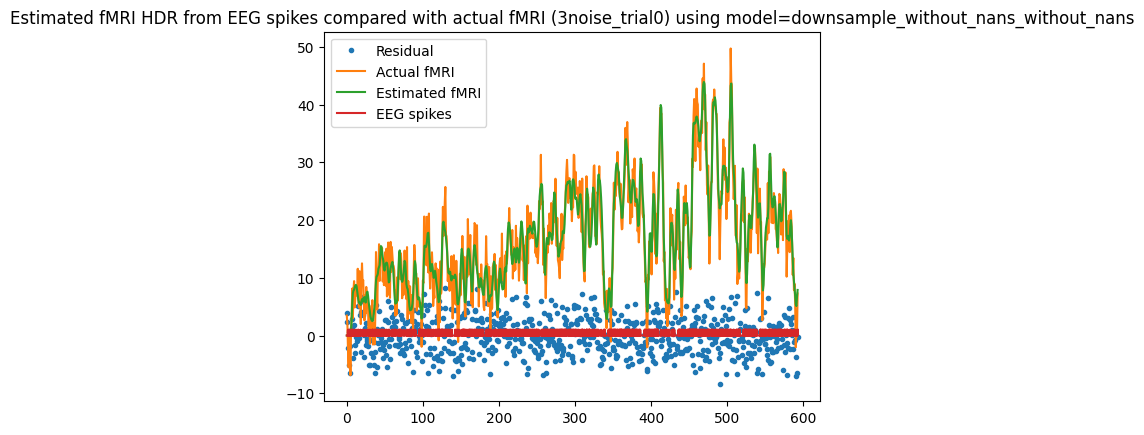

Residual Variance is 9.936549


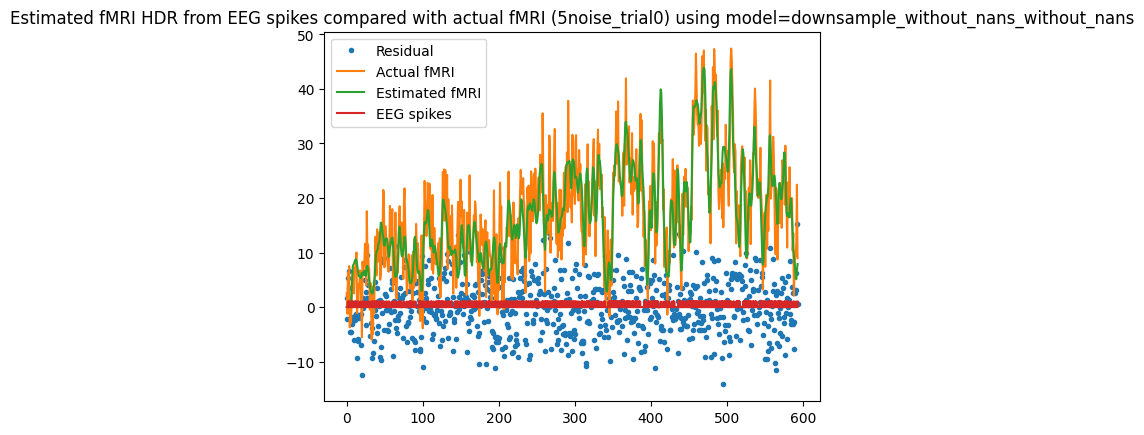

Residual Variance is 24.743270


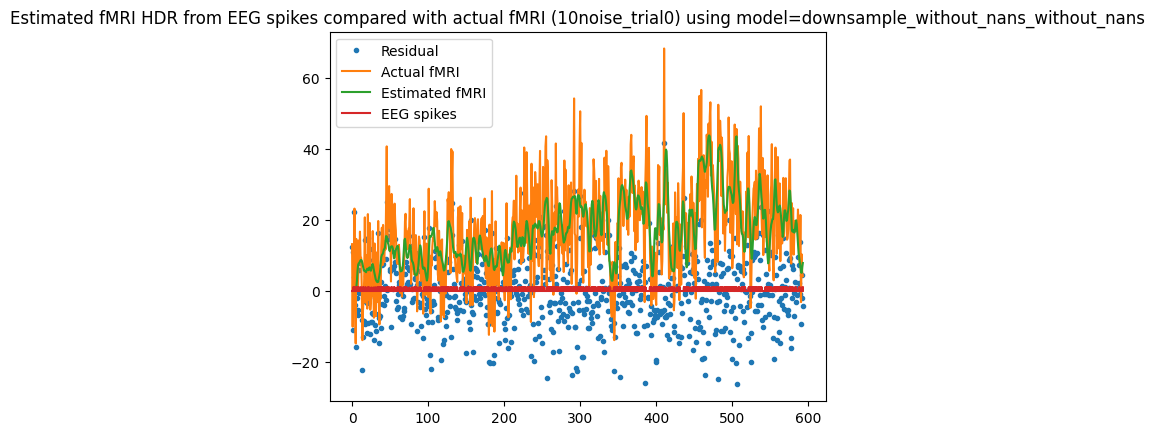

Residual Variance is 97.148307


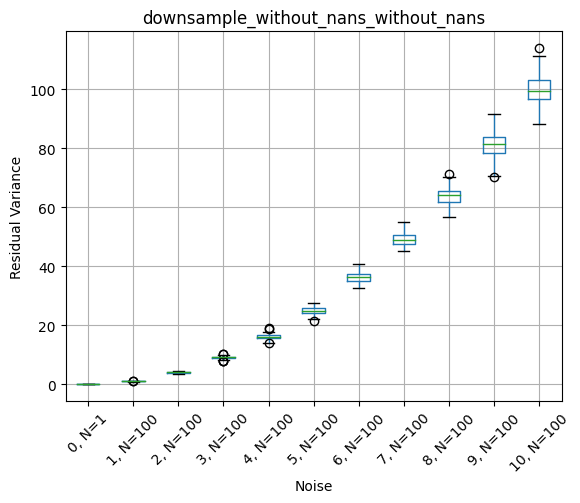

Scoring downsample_without_nans_with_nans delta=3, tau=1.25, alpha=2.25


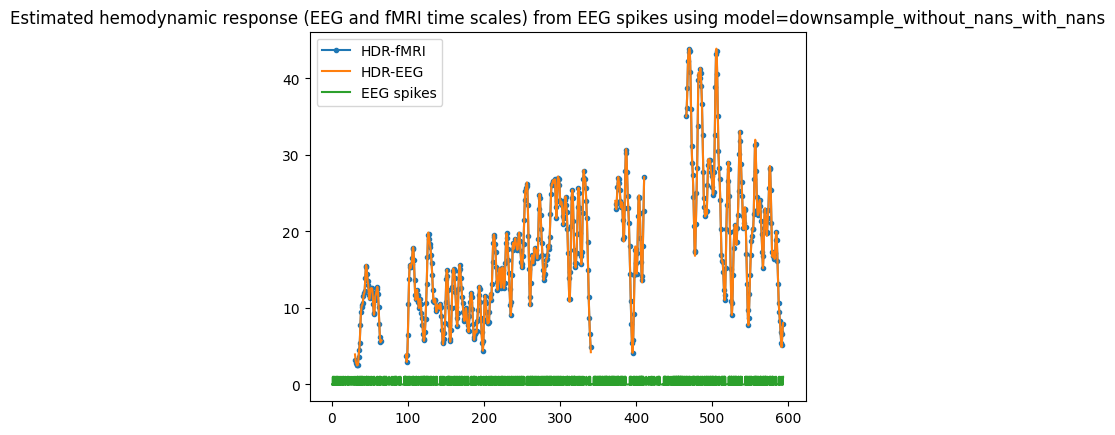

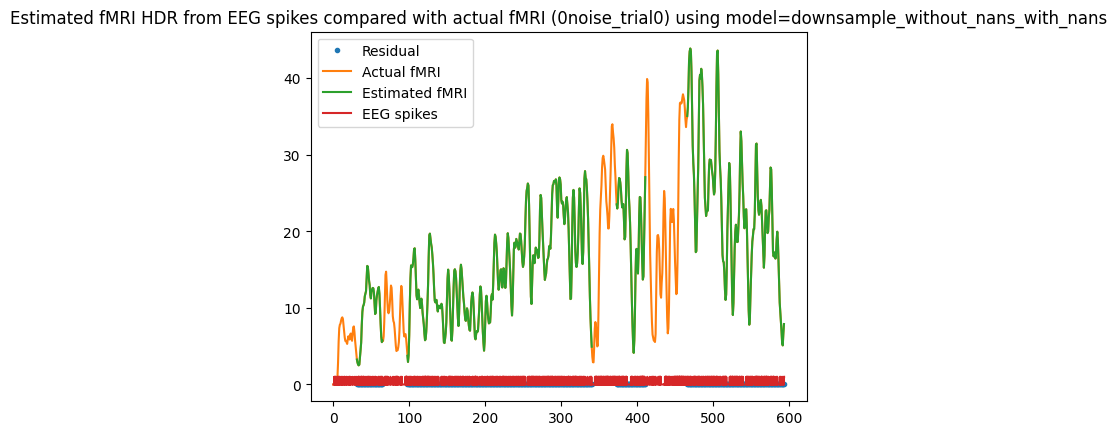

Residual Variance is 0.000000


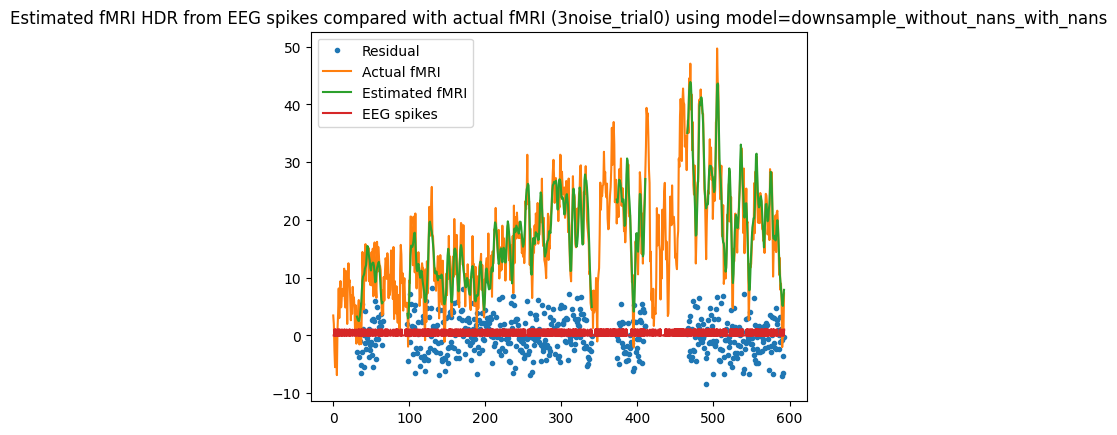

Residual Variance is 10.328919


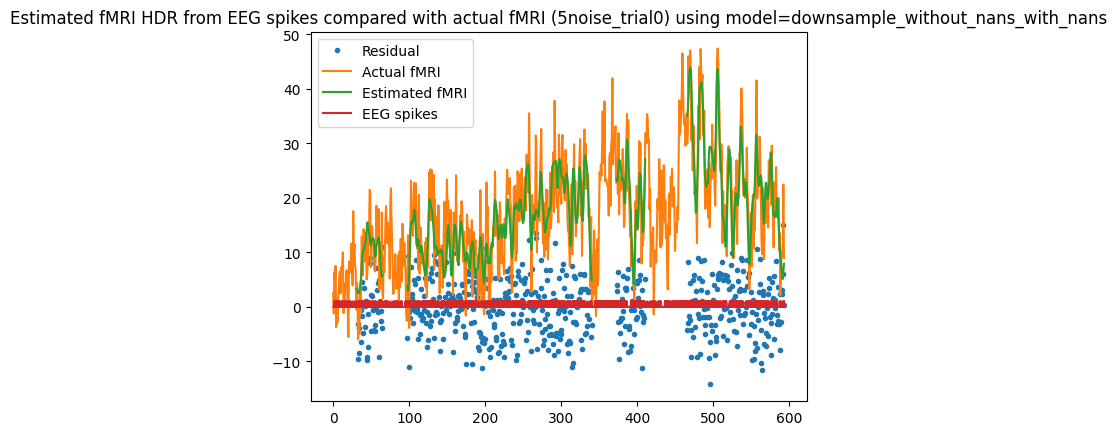

Residual Variance is 26.590353


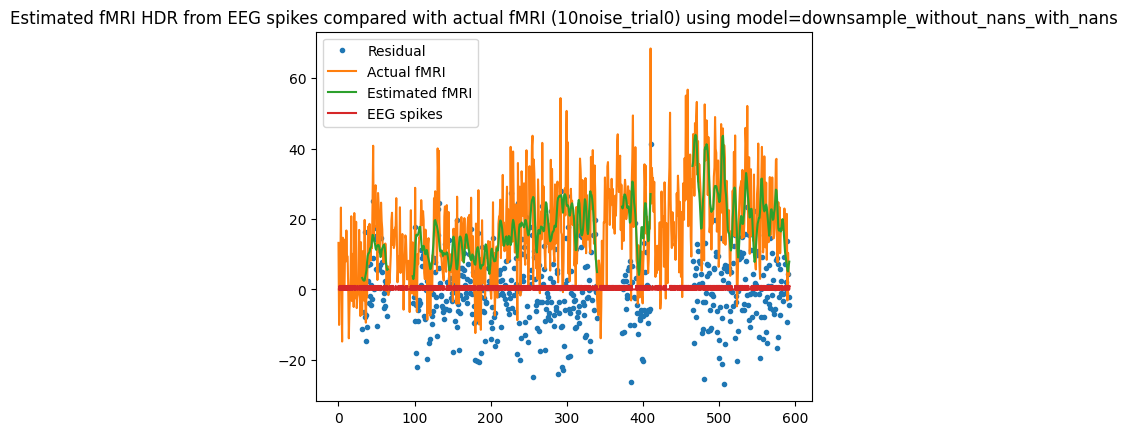

Residual Variance is 101.353998


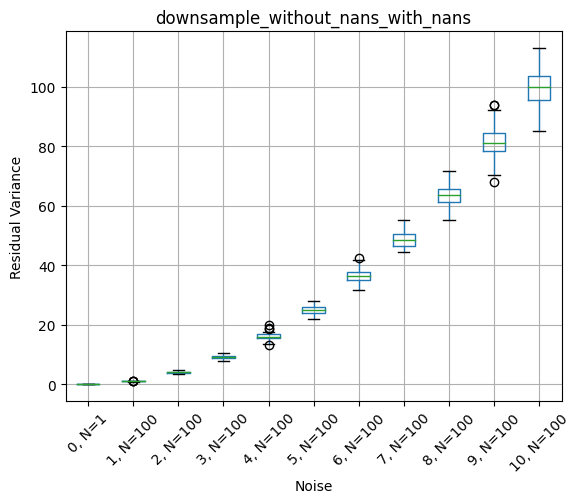

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   59.21480503538111   
1         downsample_without_nans_with_nans   52.64443327699465   
2      downsample_without_nans_without_nans   58.66247850909789   
3         downsample_without_nans_with_nans    52.2126975978255   
4      downsample_without_nans_without_nans  58.097604662851005   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans     4.4308306518612   
18938  downsample_without_nans_without_nans   5.539325943690916   
18939     downsample_without_nans_with_nans   4.965020055700908   
18940  downsample_without_nans_without_nans    6.16320125274571   
18941     downsample_without_nans_with_nans    5.52006295504343   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       59.73268236203066   63.71806675304621   69.34038312755867   
1       53.69365536453397   56.14357343545947   63.12600808232538   
2       59.20129750538871    63.1467433925208   68.78045566458141   
3       53.28387382605735  55.690635688503654   62.68555744739917   
4      58.657428121939816   62.56308442245879   68.20757121048553   
...                   ...                 ...                 ...   
18937   5.412723298648741    9.01306653172625   15.97628585998739   
18938     6.2732485492549  10.493605814714945   16.41476024594216   
18939   5.939157329221977   9.557416804149929  16.579539450516616   
18940   6.877359399757994  11.155436272958596  17.088980337216352   
18941    6.48760714722794  10.121247225371853  17.202679839554925   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       76.32098916491502   77.85395662521292  ...  60.233096359381484   
1       69.30359538427737     75.093052759105  ...   53.87932963506103   
2       75.73082477693693   77.35388027988002  ...   59.68437363986311   
3       68.87501763857979   74.71865225232136  ...   53.44792303204911   
4       75.12870175569716    76.8444151048779  ...  59.123228187382935   
...                   ...                 ...  ...                 ...   
18937  21.207289050100044  30.125335403448783  ...   5.389642389361509   
18938  22.934017180285185   28.88685350347054  ...   6.308188288310111   
18939  21.750083947651408  30.576109220694068  ...   5.927830661661607   
18940  23.592049159094643  29.406845901551335  ...   6.926053443223777   
18941   22.31560469806587  31.048272230133577  ...   6.487292994393372   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       63.95352688375664   68.68587624272843    80.6483550307131   
1       56.44817774000878  63.126128559091654   74.62832255018816   
2      63.389885329356716   68.15537734398006   80.06407129646483   
3      56.015903936600644   62.70120401827911   74.18186045593673   
4       62.81355578323229   67.61261929910147   79.46663404814373   
...                   ...                 ...                 ...   
18937   8.523110094920055  13.060832221114829  24.775621505752426   
18938   9.980007985252215  13.988459094815848   25.62685194553212   
18939    9.05269809574099  13.567410826090722  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.0116296224813739e-28; at
       delta   tau  alpha
18720    3.0  1.25   2.25


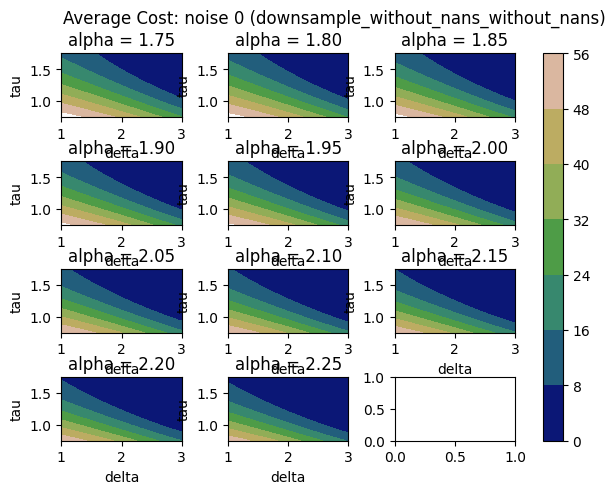

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              59.214805             
2                                              58.662479             
4                                              58.097605             
6                                              57.520223             
8                                              56.930394             
...                                                  ...             
18932                                           3.826162             
18934                                           4.368258             
18936                                           4.940176             
18938                                           5.539326             
18940                                           6.163201             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.25, Alpha target: 2.25


delta   tau  alpha
0    3.0  1.25   2.25

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.25, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  1.011630e-28    3.0  1.25   2.25
1      0         0  9.017496e-03    3.0  1.30   2.15

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
0      0         0  1.011630e-28    3.0  1.25   2.25
1      0         0  9.017496e-03    3.0  1.30   2.15

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  1.011630e-28    3.0  1.25   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.3329359891334113e-28; at
       delta   tau  alpha
18721    3.0  1.25   2.25


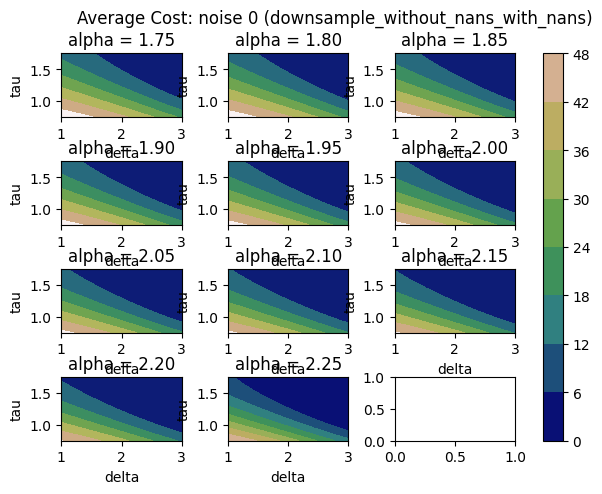

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              52.644433          
3                                              52.212698          
5                                              51.768986          
7                                              51.313229          
9                                              50.845378          
...                                                  ...          
18933                                           3.434952          
18935                                           3.919956          
18937                                           4.430831          
18939                                           4.965020          
18941                                           5.520063          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.25, Alpha target: 2.25


delta   tau  alpha
0    3.0  1.25   2.25

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.25, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  1.332936e-28    3.0  1.25   2.25
1      0         0  8.699766e-03    3.0  1.30   2.15

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
0      0         0  1.332936e-28    3.0  1.25   2.25
1      0         0  8.699766e-03    3.0  1.30   2.15

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  1.332936e-28    3.0  1.25   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9932520672865117; at
       delta   tau  alpha
18720    3.0  1.25   2.25


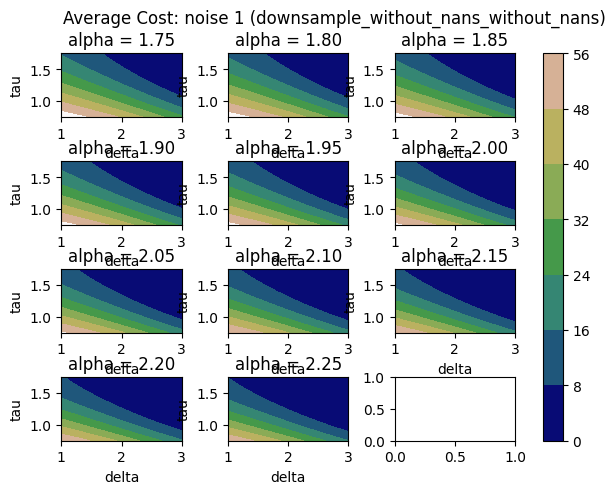

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.973863114601027; at
       delta   tau  alpha
18720    3.0  1.25   2.25


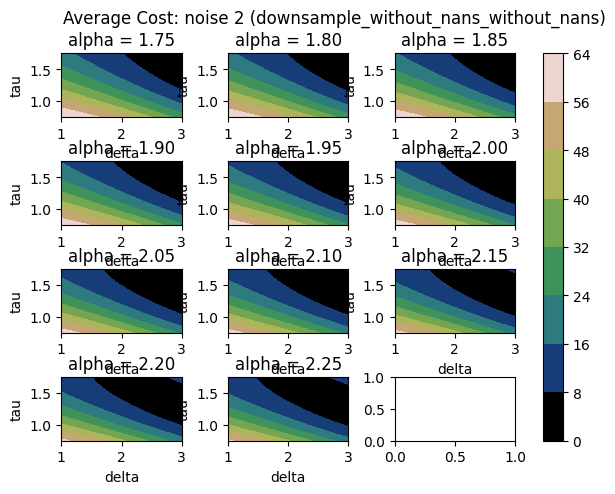

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.063322142606417; at
       delta   tau  alpha
18720    3.0  1.25   2.25


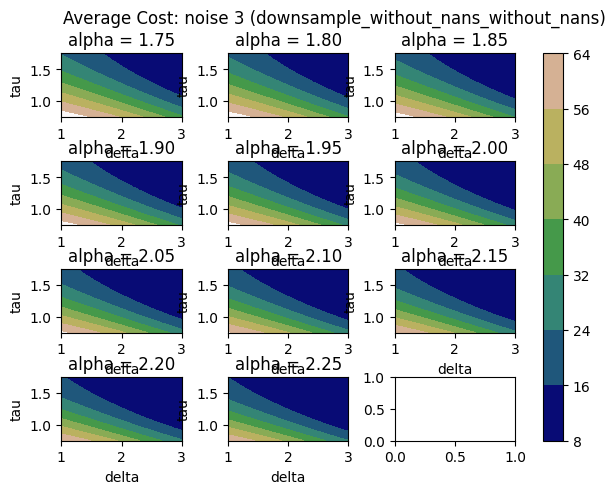

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.026805891085647; at
       delta   tau  alpha
18720    3.0  1.25   2.25


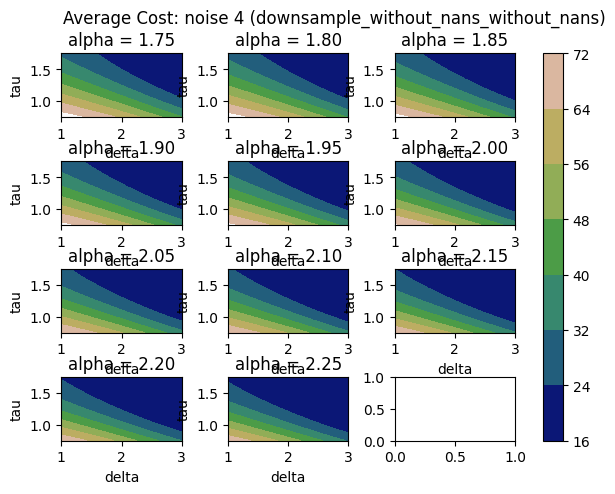

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.90358748332305; at
       delta   tau  alpha
18720    3.0  1.25   2.25


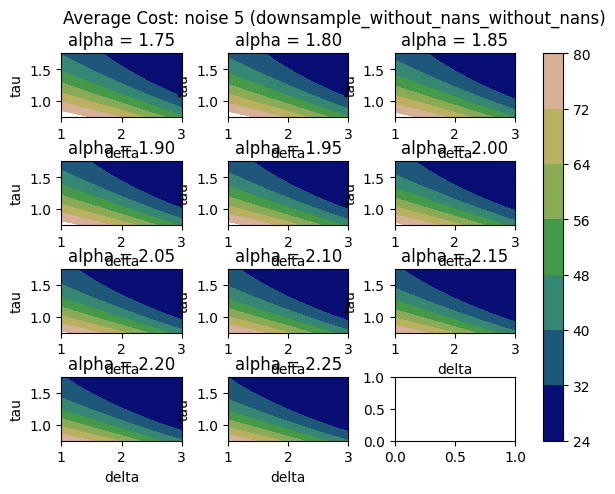

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.390396832966424; at
       delta   tau  alpha
18720    3.0  1.25   2.25


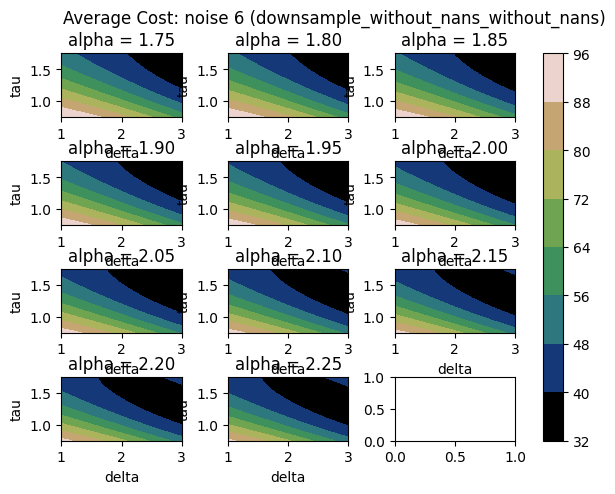

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.00367081574259; at
       delta   tau  alpha
18720    3.0  1.25   2.25


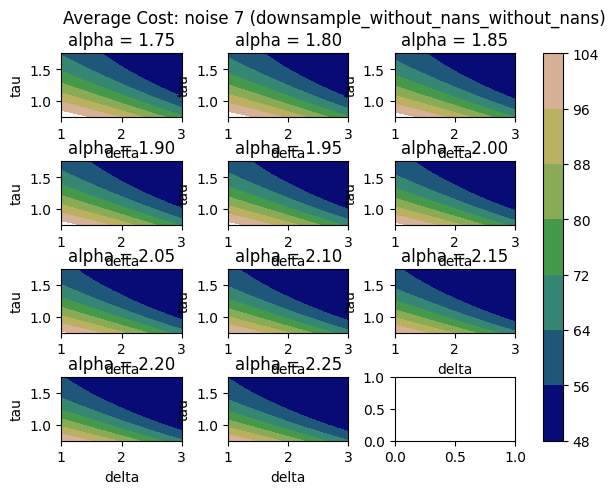

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.74856068758872; at
       delta   tau  alpha
18720    3.0  1.25   2.25


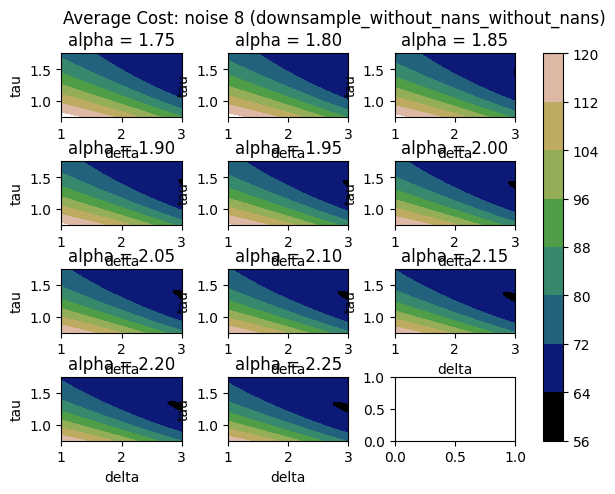

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.12908839615065; at
       delta   tau  alpha
18720    3.0  1.25   2.25


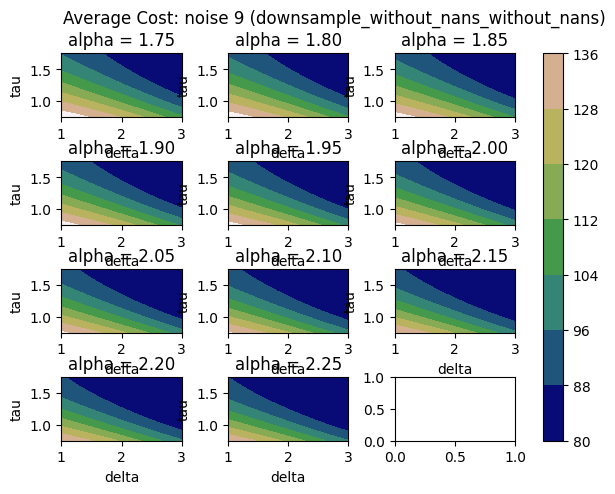

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.72070972022318; at
       delta  tau  alpha
18740    3.0  1.3    2.2


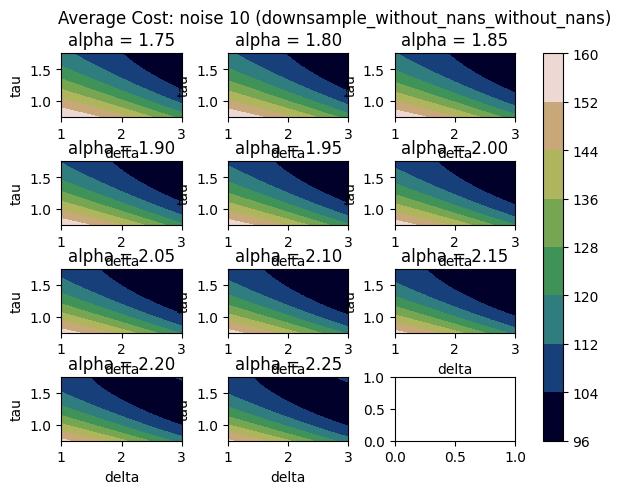

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

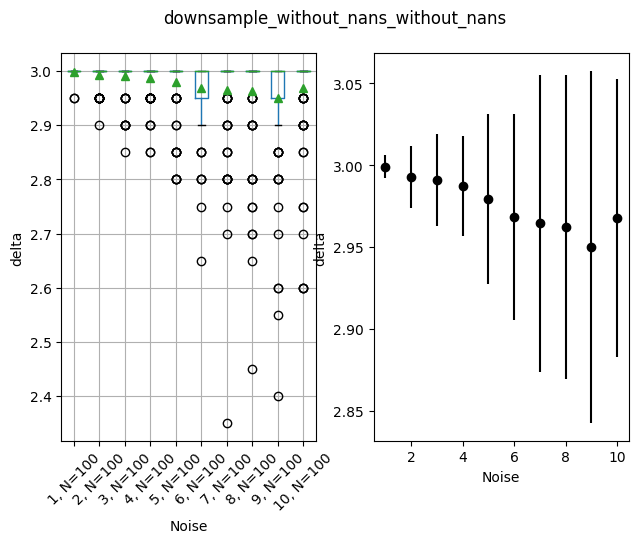

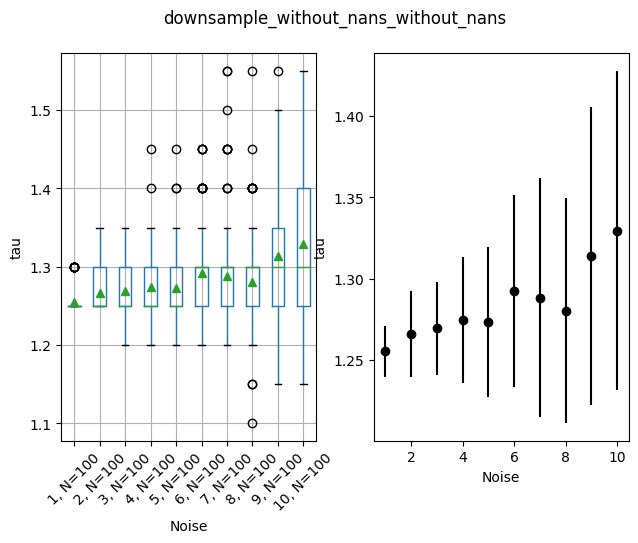

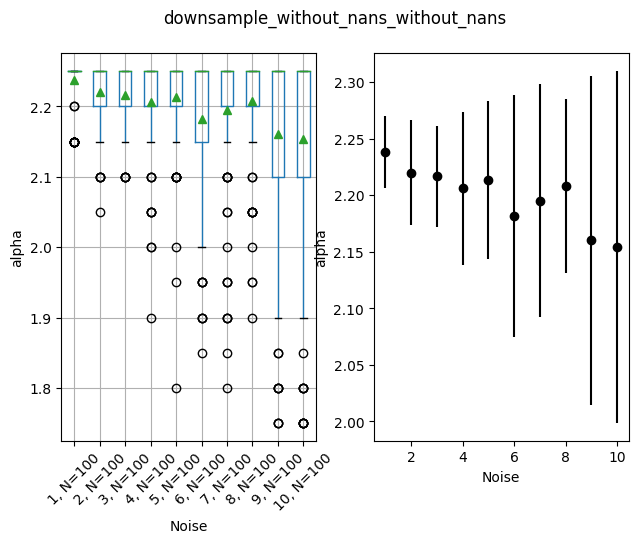

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9895492581855251; at
       delta   tau  alpha
18721    3.0  1.25   2.25


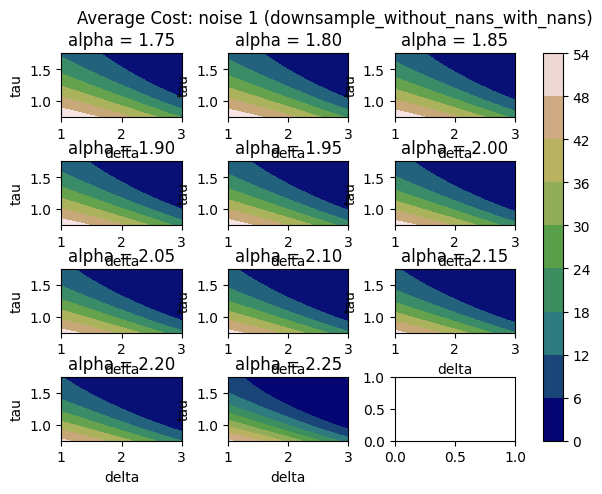

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9925345879752716; at
       delta   tau  alpha
18721    3.0  1.25   2.25


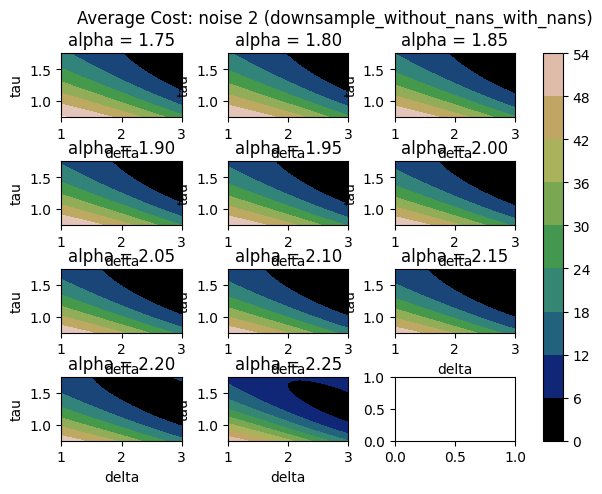

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.056295096403588; at
       delta   tau  alpha
18721    3.0  1.25   2.25


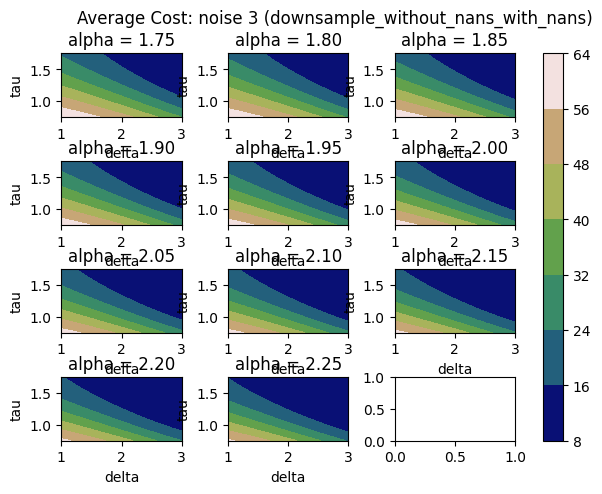

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.05431372887601; at
       delta   tau  alpha
18721    3.0  1.25   2.25


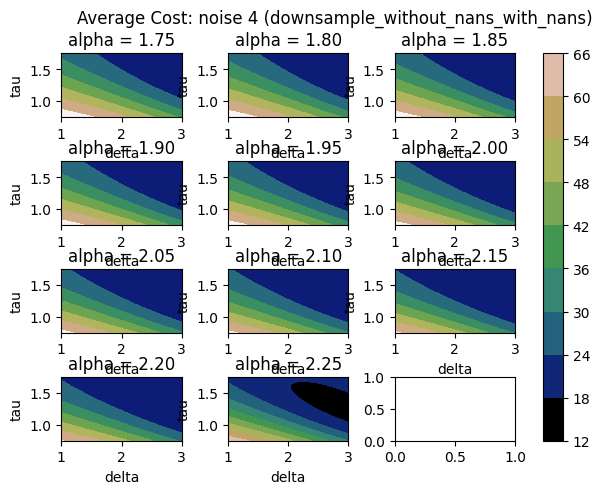

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.8541031630097; at
       delta   tau  alpha
18721    3.0  1.25   2.25


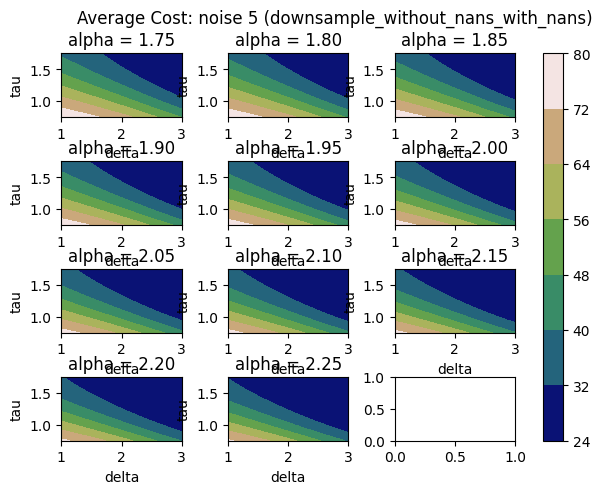

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.4650441562161; at
       delta   tau  alpha
18721    3.0  1.25   2.25


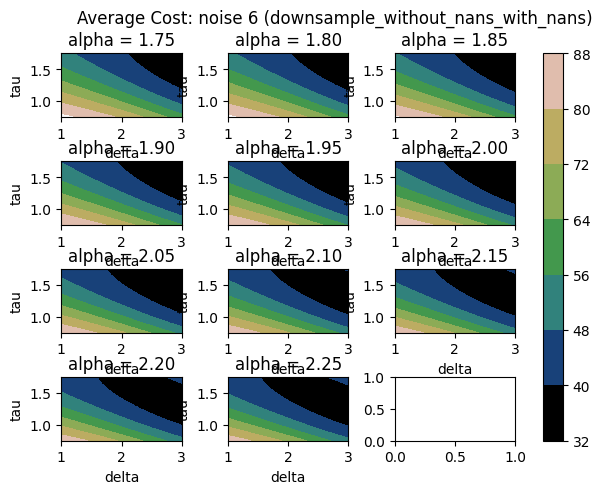

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.76575214461289; at
       delta   tau  alpha
18721    3.0  1.25   2.25


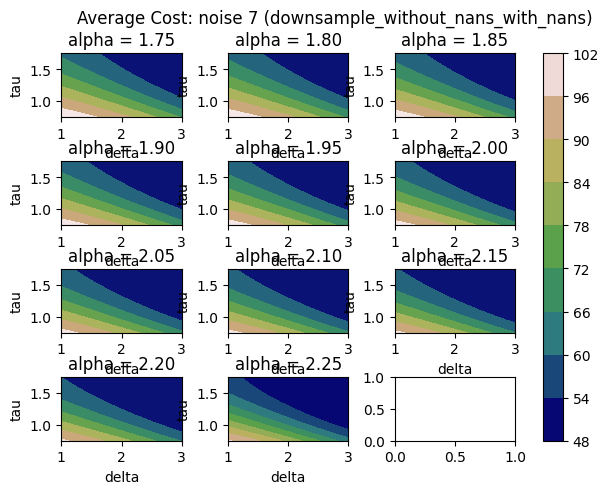

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.38665723299298; at
       delta   tau  alpha
18721    3.0  1.25   2.25


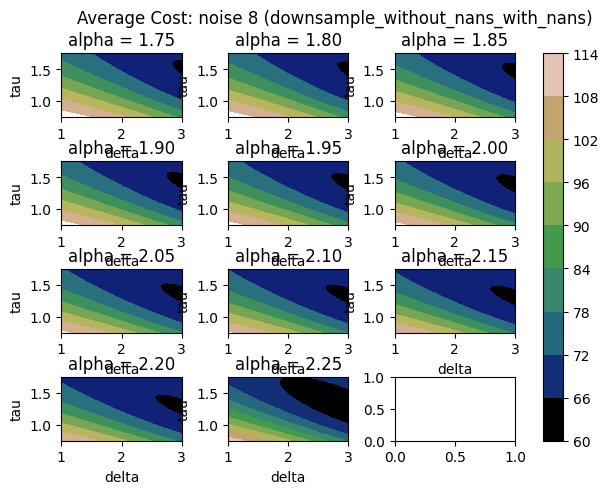

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.4546184185177; at
       delta   tau  alpha
18721    3.0  1.25   2.25


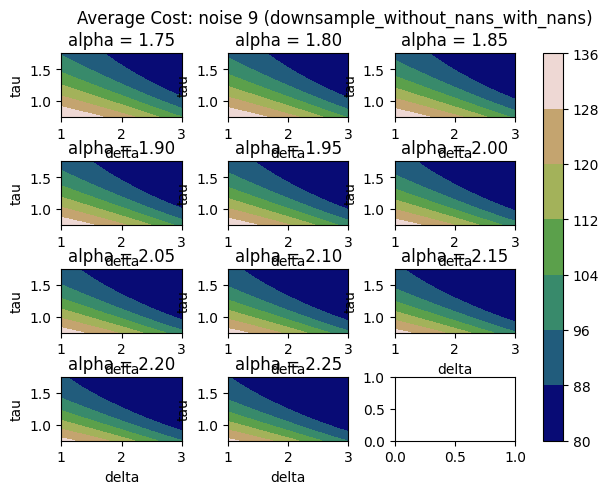

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.61994571982943; at
       delta  tau  alpha
18741    3.0  1.3    2.2


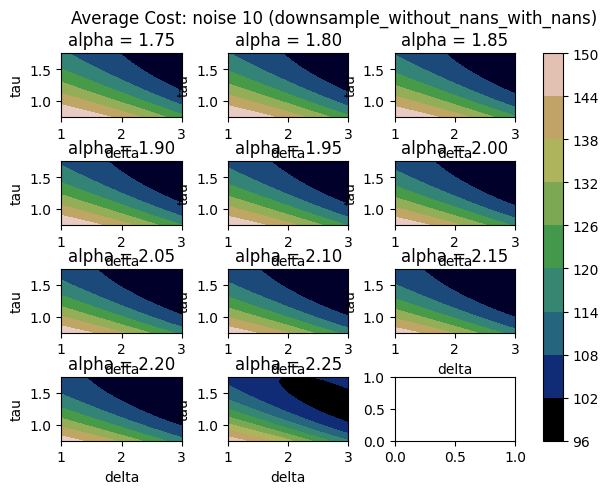

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


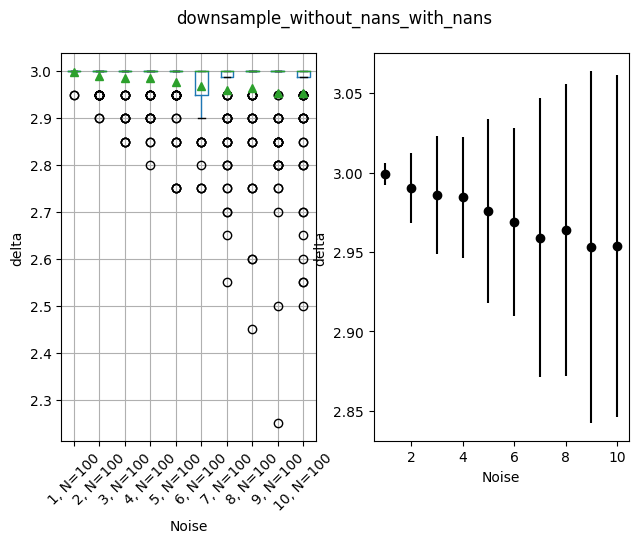

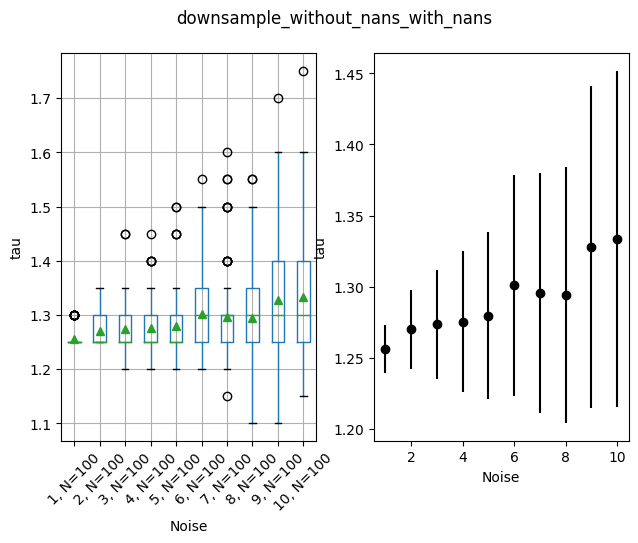

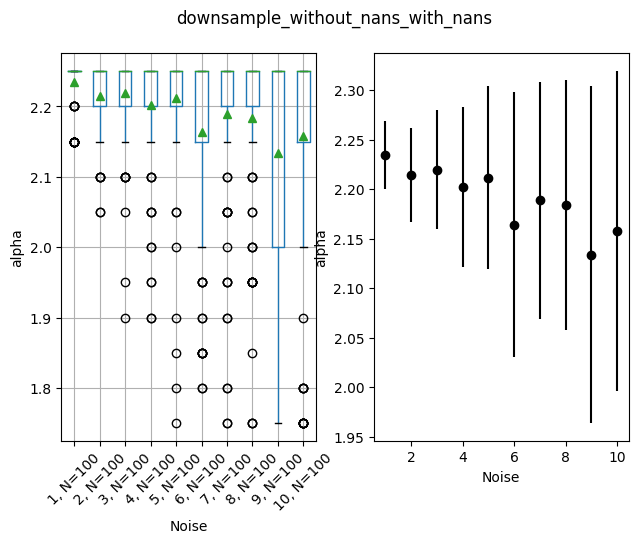

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        79    1.019448   2.950000000000002  1.2500000000000004   
1         1        87    0.946185   2.950000000000002  1.2500000000000004   
2         1        89    0.992495   2.950000000000002  1.2500000000000004   
3         1        45    1.009177  3.0000000000000018  1.2500000000000004   
4         1        71    1.060130  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1790     10        77   97.156798  3.0000000000000018  1.5500000000000007   
1791     10        88   96.492288  3.0000000000000018  1.5500000000000007   
1792     10        11  106.602733  3.0000000000000018  1.5500000000000007   
1793     10        97  112.967993  3.0000000000000018  1.5500000000000007   
1794     10        97  112.968739  3.0000000000000018  1.6000000000000008   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3                    2.2  
4                    2.2  
...                  ...  
1790                1.75  
1791                1.75  
1792                 1.8  
1793                 2.0  
1794  1.9000000000000001  

[1795 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.19  0.614554  1.0  2.0  2.0  3.0  3.0
2                      100.0  1.96  0.764358  1.0  1.0  2.0  3.0  3.0
3                      100.0  1.87  0.760847  1.0  1.0  2.0  2.0  4.0
4                      100.0  1.82  0.821184  1.0  1.0  2.0  2.0  4.0
5                      100.0  1.65  0.833333  1.0  1.0  1.0  2.0  4.0
6                      100.0  1.80  0.910100  1.0  1.0  2.0  2.0  4.0
7                      100.0  1.61  0.815197  1.0  1.0  1.0  2.0  4.0
8                      100.0  1.58  0.818720  1.0  1.0  1.0  2.0  5.0
9                      100.0  1.86  1.101147  1.0  1.0  1.0  3.0  6.0
10                     100.0  1.61  0.886430  1.0  1.0  1.0  2.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
3         1        45    1.009177  3.0000000000000018  1.2500000000000004   
4         1        71    1.060130  3.0000000000000018  1.2500000000000004   
5         1         0    1.004191  3.0000000000000018  1.2500000000000004   
6         1         1    0.989119  3.0000000000000018  1.2500000000000004   
7         1         2    0.983794  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1790     10        77   97.156798  3.0000000000000018  1.5500000000000007   
1791     10        88   96.492288  3.0000000000000018  1.5500000000000007   
1792     10        11  106.602733  3.0000000000000018  1.5500000000000007   
1793     10        97  112.967993  3.0000000000000018  1.5500000000000007   
1794     10        97  112.968739  3.0000000000000018  1.6000000000000008   

                   alpha  
3                    2.2  
4                    2.2  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
...                  ...  
1790                1.75  
1791                1.75  
1792                 1.8  
1793                 2.0  
1794  1.9000000000000001  

[1442 rows x 6 columns]

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
1104      6        32   37.256510  3.0000000000000018  1.4000000000000006   
1444      8        83   64.999520  3.0000000000000018  1.5000000000000007   
1485      9         4   79.026323  2.8500000000000014  1.5000000000000007   
1499      9        47   84.076235  2.9000000000000017  1.5000000000000007   
1600      9         1   80.767774  3.0000000000000018  1.4000000000000006   
1617      9        29   81.966985  3.0000000000000018  1.4500000000000006   
1679     10        69   98.767918   2.950000000000002  1.5500000000000007   
1744     10        32   87.616172  3.0000000000000018  1.3500000000000005   
1783     10        19   98.430474  3.0000000000000018  1.5000000000000007   
1784     10        59   94.824904  3.0000000000000018  1.5000000000000007   
1788     10        53   91.925138  3.0000000000000018  1.5500000000000007   
1789     10        70  101.499041  3.0000000000000018  1.5500000000000007   
1790     10        77   97.156798  3.0000000000000018  1.5500000000000007   
1791     10        88   96.492288  3.0000000000000018  1.5500000000000007   

     alpha  
1104  1.75  
1444  1.75  
1485  1.75  
1499  1.75  
1600  1.75  
1617  1.75  
1679  1.75  
1744  1.75  
1783  1.75  
1784  1.75  
1788  1.75  
1789  1.75  
1790  1.75  
1791  1.75

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10        8      2  3.0000000000000018    7     8      3  1.5500000000000007   
6         1      1  3.0000000000000018    1     1      1  1.4000000000000006   
8         1      1  3.0000000000000018    1     1      1  1.5000000000000007   
9         4      3  3.0000000000000018    2     4      3  1.5000000000000007   

            
      freq  
noise       
10       5  
6        1  
8        1  
9        2

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        79    1.019448   2.950000000000002  1.2500000000000004   
1         1        87    0.946185   2.950000000000002  1.2500000000000004   
2         1        89    0.992495   2.950000000000002  1.2500000000000004   
5         1         0    1.004191  3.0000000000000018  1.2500000000000004   
6         1         1    0.989119  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1760     10        52  100.976327  3.0000000000000018  1.3500000000000005   
1761     10        68   97.262307  3.0000000000000018  1.3500000000000005   
1762     10        81   91.016927  3.0000000000000018  1.3500000000000005   
1763     10        89   97.281041  3.0000000000000018  1.3500000000000005   
1776     10        12  103.665576  3.0000000000000018  1.4000000000000006   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
...                  ...  
1760  2.2500000000000004  
1761  2.2500000000000004  
1762  2.2500000000000004  
1763  2.2500000000000004  
1776  2.2500000000000004  

[708 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        97      2  3.0000000000000018   94    97      1  1.2500000000000004   
10       63      7  3.0000000000000018   49    63      7  1.2500000000000004   
2        74      2  3.0000000000000018   62    74      2  1.2500000000000004   
3        73      4  3.0000000000000018   59    73      3  1.2500000000000004   
4        61      4  3.0000000000000018   47    61      3  1.2500000000000004   
5        67      6  3.0000000000000018   51    67      4  1.2500000000000004   
6        70      7  3.0000000000000018   39    70      4  1.2500000000000004   
7        72      9  3.0000000000000018   49    72      5  1.2500000000000004   
8        66      8  3.0000000000000018   52    66      7  1.3000000000000005   
9        65      9  3.0000000000000018   43    65      7  1.2500000000000004   

            
      freq  
noise       
1       97  
10      18  
2       72  
3       64  
4       49  
5       41  
6       40  
7       29  
8       24  
9       20

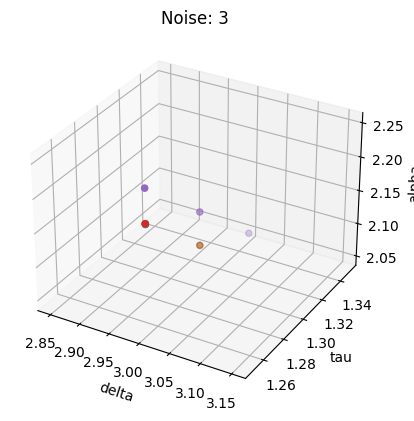

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

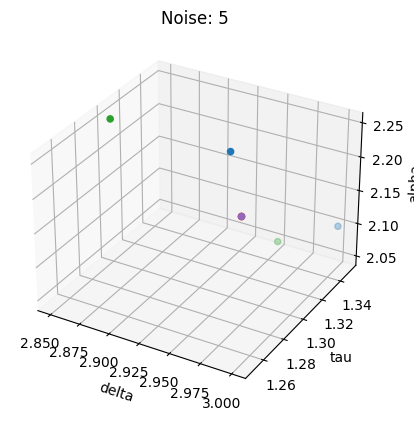

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

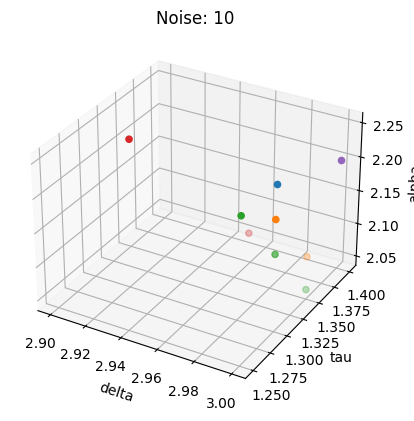

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        79    0.963618   2.950000000000002  1.2500000000000004   
1         1        87    0.905698   2.950000000000002  1.2500000000000004   
2         1        89    1.030675   2.950000000000002  1.2500000000000004   
3         1        15    0.937787  3.0000000000000018  1.2500000000000004   
4         1        45    0.962842  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1642     10        27  103.078199  3.0000000000000018  1.5000000000000007   
1643     10        56   94.977323  3.0000000000000018  1.5000000000000007   
1644     10         4   94.994289  3.0000000000000018  1.5000000000000007   
1645     10        70  100.309006  3.0000000000000018  1.5500000000000007   
1646     10        97  112.160596  3.0000000000000018  1.6000000000000008   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3                    2.2  
4                    2.2  
...                  ...  
1642  2.0500000000000003  
1643  2.1000000000000005  
1644  2.1500000000000004  
1645                1.75  
1646  1.9000000000000001  

[1647 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  1.96  0.665453  1.0  2.0  2.0  2.0  3.0
2                      100.0  1.80  0.724743  1.0  1.0  2.0  2.0  3.0
3                      100.0  1.67  0.752840  1.0  1.0  2.0  2.0  4.0
4                      100.0  1.61  0.764027  1.0  1.0  1.0  2.0  3.0
5                      100.0  1.52  0.717459  1.0  1.0  1.0  2.0  3.0
6                      100.0  1.68  0.983500  1.0  1.0  1.0  2.0  5.0
7                      100.0  1.62  0.907655  1.0  1.0  1.0  2.0  5.0
8                      100.0  1.63  0.906263  1.0  1.0  1.0  2.0  4.0
9                      100.0  1.61  0.941683  1.0  1.0  1.0  2.0  5.0
10                     100.0  1.37  0.613896  1.0  1.0  1.0  2.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
3         1        15    0.937787  3.0000000000000018  1.2500000000000004   
4         1        45    0.962842  3.0000000000000018  1.2500000000000004   
5         1        55    0.983213  3.0000000000000018  1.2500000000000004   
6         1        71    1.073423  3.0000000000000018  1.2500000000000004   
7         1        82    0.948652  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1642     10        27  103.078199  3.0000000000000018  1.5000000000000007   
1643     10        56   94.977323  3.0000000000000018  1.5000000000000007   
1644     10         4   94.994289  3.0000000000000018  1.5000000000000007   
1645     10        70  100.309006  3.0000000000000018  1.5500000000000007   
1646     10        97  112.160596  3.0000000000000018  1.6000000000000008   

                   alpha  
3                    2.2  
4                    2.2  
5                    2.2  
6                    2.2  
7                    2.2  
...                  ...  
1642  2.0500000000000003  
1643  2.1000000000000005  
1644  2.1500000000000004  
1645                1.75  
1646  1.9000000000000001  

[1279 rows x 6 columns]

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost              delta                 tau alpha
1548     10        14  87.849177  2.950000000000002  1.7500000000000009  1.75

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
853       5        49   23.778167  3.0000000000000018  1.5000000000000007   
993       6        32   36.711345  3.0000000000000018  1.4000000000000006   
1010      6        55   35.702470  3.0000000000000018  1.4500000000000006   
1021      6        39   34.842373  3.0000000000000018  1.5500000000000007   
1023      6        18   34.541537  3.0000000000000018  1.6000000000000008   
1052      7        37   46.844553  2.8500000000000014  1.4500000000000006   
1054      7        50   49.015086  2.8500000000000014  1.6000000000000008   
1181      7        67   45.353131  3.0000000000000018  1.5000000000000007   
1299      8        48   67.705026  3.0000000000000018  1.3500000000000005   
1336      8        25   60.733338  3.0000000000000018  1.4500000000000006   
1343      8        87   66.567727  3.0000000000000018  1.5000000000000007   
1346      8        41   66.168755  3.0000000000000018  1.5500000000000007   
1372      9        78   87.534900  2.8000000000000016  1.7000000000000008   
1392      9        33   75.056268  2.9000000000000017  1.6000000000000008   
1397      9         1   82.377594   2.950000000000002  1.5000000000000007   
1479      9        62   82.519942  3.0000000000000018  1.4000000000000006   
1480      9        84   82.616039  3.0000000000000018  1.4000000000000006   
1489      9        29   84.240673  3.0000000000000018  1.4500000000000006   
1504      9        79   75.653511  3.0000000000000018  1.5500000000000007   
1505      9        81   80.083063  3.0000000000000018  1.5500000000000007   
1535     10        77  104.948089  2.9000000000000017  1.5500000000000007   
1536     10        47  108.912973  2.9000000000000017  1.6000000000000008   
1546     10         5  101.513718   2.950000000000002  1.5500000000000007   
1547     10        88   95.083792   2.950000000000002  1.6000000000000008   
1548     10        14   87.849177   2.950000000000002  1.7500000000000009   
1622     10        36   93.599535  3.0000000000000018  1.4000000000000006   
1639     10        75  100.183328  3.0000000000000018  1.5000000000000007   
1645     10        70  100.309006  3.0000000000000018  1.5500000000000007   

     alpha  
853   1.75  
993   1.75  
1010  1.75  
1021  1.75  
1023  1.75  
1052  1.75  
1054  1.75  
1181  1.75  
1299  1.75  
1336  1.75  
1343  1.75  
1346  1.75  
1372  1.75  
1392  1.75  
1397  1.75  
1479  1.75  
1480  1.75  
1489  1.75  
1504  1.75  
1505  1.75  
1535  1.75  
1536  1.75  
1546  1.75  
1547  1.75  
1548  1.75  
1622  1.75  
1639  1.75  
1645  1.75

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
10        8      3   2.950000000000002    3     8      5  1.5500000000000007   
5         1      1  3.0000000000000018    1     1      1  1.5000000000000007   
6         4      1  3.0000000000000018    4     4      4  1.4000000000000006   
7         3      2  2.8500000000000014    2     3      3  1.4500000000000006   
8         4      1  3.0000000000000018    4     4      4  1.3500000000000005   
9         8      4  3.0000000000000018    5     8      6  1.4000000000000006   

            
      freq  
noise       
10       3  
5        1  
6        1  
7        1  
8        1  
9        2

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        79    0.963618   2.950000000000002  1.2500000000000004   
1         1        87    0.905698   2.950000000000002  1.2500000000000004   
2         1        89    1.030675   2.950000000000002  1.2500000000000004   
8         1         0    1.030005  3.0000000000000018  1.2500000000000004   
9         1         1    0.993635  3.0000000000000018  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1630     10        21   92.515921  3.0000000000000018  1.4000000000000006   
1631     10        28   97.487482  3.0000000000000018  1.4000000000000006   
1632     10        52   94.777403  3.0000000000000018  1.4000000000000006   
1637     10         4   94.985894  3.0000000000000018  1.4500000000000006   
1638     10        16  108.848858  3.0000000000000018  1.4500000000000006   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
8     2.2500000000000004  
9     2.2500000000000004  
...                  ...  
1630  2.2500000000000004  
1631  2.2500000000000004  
1632  2.2500000000000004  
1637  2.2500000000000004  
1638  2.2500000000000004  

[699 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        88      2  3.0000000000000018   85    88      1  1.2500000000000004   
10       69     11  3.0000000000000018   46    69      9  1.3000000000000005   
2        61      3  3.0000000000000018   52    61      3  1.2500000000000004   
3        71      4  3.0000000000000018   54    71      4  1.2500000000000004   
4        62      5  3.0000000000000018   45    62      4  1.2500000000000004   
5        73      6  3.0000000000000018   54    73      4  1.2500000000000004   
6        65      7  3.0000000000000018   38    65      5  1.2500000000000004   
7        67      9  3.0000000000000018   50    67      6  1.2500000000000004   
8        76      8  3.0000000000000018   51    76      8  1.3000000000000005   
9        67      9  3.0000000000000018   44    67      9  1.3000000000000005   

            
      freq  
noise       
1       88  
10      21  
2       57  
3       53  
4       43  
5       38  
6       33  
7       24  
8       21  
9       23

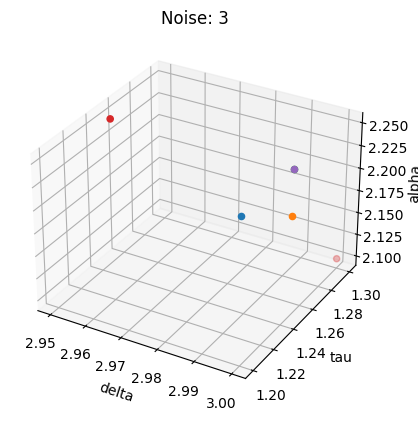

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

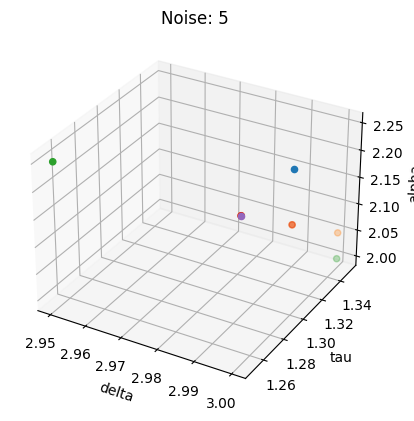

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

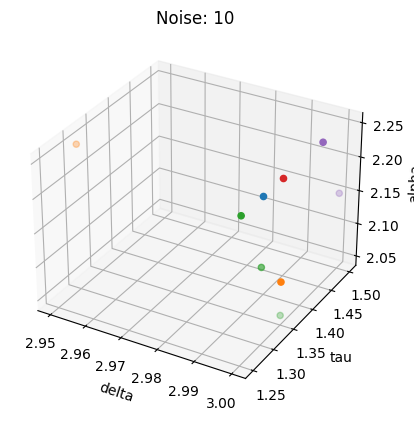

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()